# Setup Variables

In [108]:
REPO_PATH = '/home/ah19/runtime-monitoring'
DATASET = 'FashionMNIST'
PREFIX = 'BestRegularization'
FILENAME_POSTFIX = f"{DATASET}_{PREFIX}"
SEED = 42

CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

model_setup = {'first_layer_norm': False, 'dropout': 0.2}

model_config = {
    'batch_size': 128,
    'lr': 0.01,
    'epochs': 15,
    "patience": 3,
    "L2": 0.00,
    "L1": 0.00
}

# Libraries

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.backends import cudnn
from torchinfo import summary

In [110]:
import os
os.chdir('..')
REPO_PATH = Path().cwd()
REPO_PATH

In [111]:
from utils import *
from plotFunctions import *
from pathManager import fetchPaths
from FashionMNIST_CNN import FashionMNIST_CNN

model_ = FashionMNIST_CNN

# GPU Device & Seed

In [112]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [113]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

# Paths

In [114]:
base = Path(REPO_PATH)
paths = fetchPaths(base, DATASET)

path = paths[DATASET.lower()]
path_dataset = paths['dataset']
path_trainingModels = paths['trainingModels']
path_lastHiddenLayer = paths['lastHiddenLayer']
path_lastHiddenLayer_raw = paths['lastHiddenLayer_raw']
path_savedModels = paths['savedModels']

# save model and logs to dedicated directory
path_savedModels = path_savedModels / FILENAME_POSTFIX
if path_savedModels.is_dir(): print('! MODEL EXISTS !')
path_savedModels.mkdir(exist_ok=True)

path, path_savedModels

! MODEL EXISTS !


(PosixPath('/home/ah19/runtime-monitoring/FashionMNIST'),
 PosixPath('/home/ah19/runtime-monitoring/FashionMNIST/savedModels/FashionMNIST_BestRegularization'))

# Load / Split / DataLoader

In [115]:
feature_names = get_labels(DATASET)

tf_train = T.Compose([
    T.ToTensor(),
    T.Normalize((0.2850), (0.3200))
])


tf_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.2850), (0.3200))
])

train_data = get_dataset(DATASET, path_dataset, train=True, transform=tf_train)
test_data = get_dataset(DATASET, path_dataset, train=False, transform=tf_test)
len(train_data), len(test_data)

(60000, 10000)

In [116]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

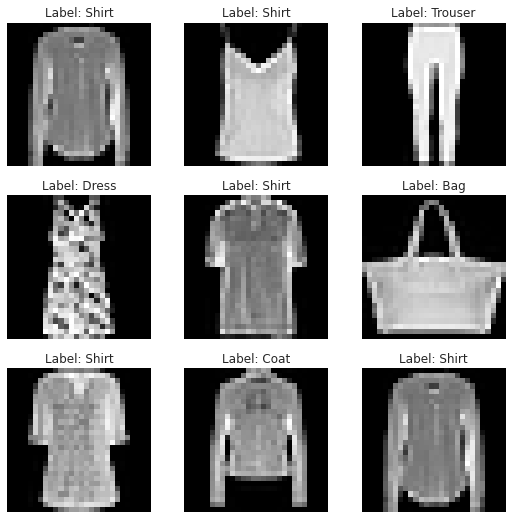

In [117]:
show_images_loader(trainloader, feature_names=feature_names)

# Model

In [118]:
# skip classes
skip_classes = None
map_classes = None

In [119]:
model = model_(**model_setup)
model.to(device)

nn.DataParallel(model, device_ids=[CUDA])
cudnn.benchmark = True

summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNIST_CNN                         --                        --
├─Conv2d: 1-1                            [1, 256, 26, 26]          2,560
├─BatchNorm2d: 1-2                       [1, 256, 26, 26]          512
├─ReLU: 1-3                              [1, 256, 26, 26]          --
├─Conv2d: 1-4                            [1, 256, 24, 24]          590,080
├─BatchNorm2d: 1-5                       [1, 256, 24, 24]          512
├─ReLU: 1-6                              [1, 256, 24, 24]          --
├─MaxPool2d: 1-7                         [1, 256, 12, 12]          --
├─Conv2d: 1-8                            [1, 128, 11, 11]          131,200
├─BatchNorm2d: 1-9                       [1, 128, 11, 11]          256
├─ReLU: 1-10                             [1, 128, 11, 11]          --
├─Conv2d: 1-11                           [1, 128, 10, 10]          65,664
├─BatchNorm2d: 1-12                      [1, 128, 10, 10]        

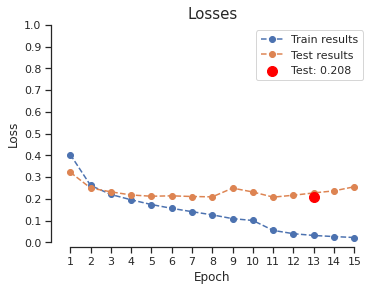

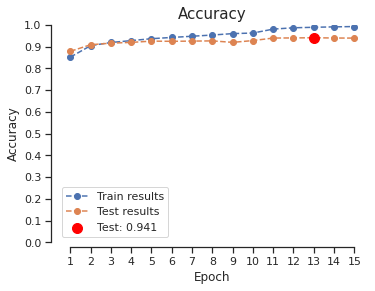

In [120]:
# cost function
loss_function = nn.CrossEntropyLoss()

# optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=model_config['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr=model_config['lr'])

# LR Scheduler

# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=2, T_mult=1, eta_min=1e-4, verbose=True)


# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=model_config['epochs'], verbose=True)

# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=model_config['patience'], mode='max',
#     factor=1e-1, min_lr=1e-4, verbose=True)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=10 )

# lr_scheduler = None

# run_training_testing arguments
kwargs = {
    'model': model,
    'loss_function': loss_function,
    'optimizer': optimizer,
    'lr_scheduler': lr_scheduler,
    'map_classes': map_classes,
    'skip_classes': skip_classes,
    'device': device,
    'model_path': path_savedModels / f"{DATASET}_{PREFIX}.pth.tar",
    'trainloader': trainloader,
    'testloader': testloader,
    'config': model_config
}

# train
train_losses, test_losses, train_accs, test_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = run_training_testing(**kwargs)

# Exporting last hidden layer data

In [121]:
# create empty model
model = model_(**model_setup)
model.to(device)

# load model
# model_file_name = path_savedModels / 'FashionMNIST_BestRegularization-acc-0.942-loss-0.215.pth.tar'
model_file_name = best_model_name
load_checkpoint(model, model_file_name)

model_file_name

PosixPath('/home/ah19/runtime-monitoring/FashionMNIST/savedModels/FashionMNIST_BestRegularization/FashionMNIST_BestRegularization-acc-0.941-loss-0.227.pth.tar')

In [122]:
# export last hidden layer for each data loader

for loader, stage in [
    (trainloader, 'train'),
    (testloader, 'test'),
]:
    export_last_hidden_layer(loader, model, device, model.last_hidden_neurons,
                          map_classes, path_lastHiddenLayer_raw, FILENAME_POSTFIX, stage)

# Confusion Matrix

In [123]:
save_confusion_matrix(confusion_matrix_test, path_savedModels, FILENAME_POSTFIX, 'test')

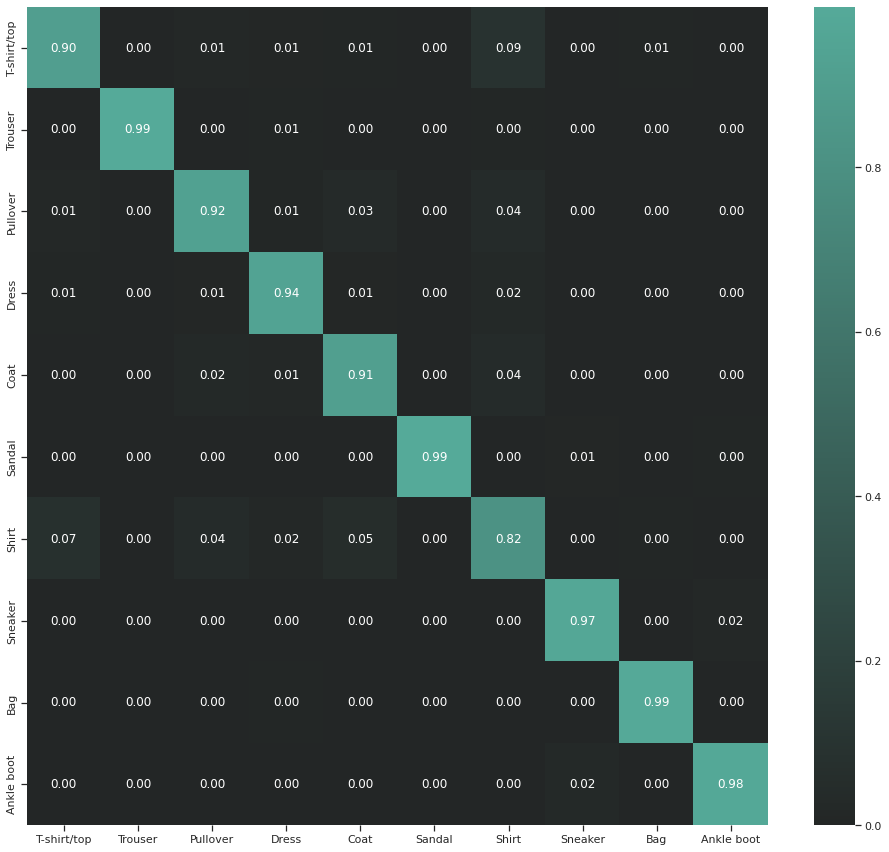

In [124]:
confusion_matrix_test_norm = normalize_confusion_matrix(confusion_matrix_test)
fig, ax = plot_confusion_matrix( confusion_matrix_test_norm, feature_names, None, fmt='.2f')